Researchers have studied various boundary integral formulations to solve the coupled Possion and linearized Poisson-Boltzmann equations. By applying Green's second identity and evaluating the potentials at the boundary, we arrive at the direct formulation, first derived by Yoon and Lenhoff [Yoon 1990]:

$$
\left[\begin{array}{cc}
\frac{\mathrm{I}}{2} + \mathrm{K_L} &
-\mathrm{V_L} \\
\frac{\mathrm{I}}{2} - \mathrm{K_Y} &
\frac{1}{\epsilon} \mathrm{V_Y}
\end{array}\right]
\left[\begin{array}{c}
\phi_{1} \\
\frac{\partial}{\partial \mathbf{n}} \phi_{1}
\end{array}\right]
=
\frac{1}{\epsilon_{1}}\left[\begin{array}{c}
\sum_{k} \frac{q_{k}}{4 \pi\left|\mathbf{r} -\mathbf{r}_k\right|} \\
0
\end{array}\right]
$$

However, it is ill-conditioned. By taking a linear combination of the two equations and taking the normal derivative, we arrive at Juffer's formulation [Juffer et al. 1991], which is better-conditioned:

$$
\left[\begin{array}{cc}
\left(\frac{1}{2}+\frac{\epsilon}{2}\right)\mathrm{I} + \left( \mathrm{K_L} - \epsilon \mathrm{K_Y}\right) &
-\left(\mathrm{V_L} - \mathrm{V_Y}\right) \\
-\left(\mathrm{D_L} - \mathrm{D_Y}\right) &
\left(\frac{1}{2\epsilon}+\frac{1}{2}\right)\mathrm{I} - \left( \mathrm{T_L} - \frac{1}{\epsilon}\mathrm{T_Y}\right)
\end{array}\right]
\left[\begin{array}{c}
\phi_{1} \\
\frac{\partial}{\partial \mathbf{n}} \phi_{1}
\end{array}\right]
=
\frac{1}{\epsilon_{1}}\left[\begin{array}{c}
\sum_{k} \frac{q_{k}}{4 \pi\left|\mathbf{r} -\mathbf{r}_k\right|} \\
\sum_{k} \frac{\partial}{\partial \mathbf{n}_{0}} \left(\frac{q_{k}}{4 \pi\left|\mathbf{r} -\mathbf{r}_k\right|} \right)
\end{array}\right]
$$

Note that the unknowns in both formulations are interior values (with subscript $1$).

Lu etal employed a similar formulation in their work [Lu et al. 2010] but with exterior values as unknowns:

$$
\left[\begin{array}{cc}
\left(\frac{1}{2\epsilon}+\frac{1}{2}\right)\mathrm{I} + \left( \mathrm{K_L} - \epsilon \mathrm{K_Y}\right) &
-\left(\mathrm{V_L} - \mathrm{V_Y}\right) \\
-\frac{1}{\epsilon} \left(\mathrm{D_L} - \mathrm{D_Y}\right) &
\left(\frac{1}{2\epsilon}+\frac{1}{2}\right)\mathrm{I} - \left( \mathrm{T_L} - \frac{1}{\epsilon}\mathrm{T_Y}\right)
\end{array}\right]
\left[\begin{array}{c}
\phi_{2} \\
\frac{\partial}{\partial \mathbf{n}} \phi_{2}
\end{array}\right]
=
\frac{1}{\epsilon_{2}}\left[\begin{array}{c}
\sum_{k} \frac{q_{k}}{4 \pi\left|\mathbf{r} -\mathbf{r}_k\right|} \\
\sum_{k} \frac{\partial}{\partial \mathbf{n}_{0}} \left(\frac{q_{k}}{4 \pi\left|\mathbf{r} -\mathbf{r}_k\right|} \right)
\end{array}\right]
$$

Their work showed great conditioning with this adaption, but lacks further explanation of their choice and the comparision with the original Juffer's formulation.

Therefore, we want to demonstrate how our high-productivity software and workflow helped us understand the difference between the two Juffer's formulations in terms of conditioning.

Let's start with importing libraries.

In [1]:
import bempp.api
import numpy as np
import scripts.helpers
import scripts.formulations

Then we create a simple geometry for this study: a unit sphere with 512 elements to represent a molecule. And let's add a unit charge at $(0.25, 0.25, 0.25)$.

In [2]:
# bempp.api.enable_console_logging('debug')
assembler = "dense"

grid = bempp.api.shapes.regular_sphere(3)           # create grid
x_q = np.array([0.25, 0.25, 0.25]).reshape(-1,3)    # charge coordinates
q = np.array([1.])

Next, we define our function space. Here we use piecewise linear functions to describe Dirichlet data and Neumann data.

In [3]:
# define function space
dirichl_space = bempp.api.function_space(grid, "P", 1)
neumann_space = dirichl_space

Now we are ready to create the system matrix and the RHS for both formulations. For simplicity, we provide helpers functions for all three formulations: `direct`, `juffer_in` and `juffer_ex`. In this case, we only use the latter two.

In [4]:
A_in, rhs1_in, rhs2_in = scripts.formulations.juffer_in(dirichl_space, neumann_space, assembler, q, x_q)
A_ex, rhs1_ex, rhs2_ex = scripts.formulations.juffer_ex(dirichl_space, neumann_space, assembler, q, x_q) 

`A_[in/ex]` are 2-by-2 blocked operators. `rhs1_[in/ex]` and `rhs2_[in/ex]` are `GridFunction`s from `bempp`.

In [5]:
print(type(A_in))
print(type(rhs1_in))

<class 'bempp.api.assembly.blocked_operator.BlockedOperator'>
<class 'bempp.api.assembly.grid_function.GridFunction'>


The last step before calling GMRES is to create NumPy arrays from the RHS grid functions.

In [6]:
from bempp.api.assembly.blocked_operator import coefficients_from_grid_functions_list
rhs_vec_in = coefficients_from_grid_functions_list([rhs1_in, rhs2_in])
rhs_vec_ex = coefficients_from_grid_functions_list([rhs1_ex, rhs2_ex])

/home/tingyu/anaconda3/envs/bempp/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [7]:
from scipy.sparse.linalg import gmres
from bempp.api.linalg.iterative_solvers import IterationCounter

Now we are ready to solve GMRES for both formulations. The tolerance is set to $10^{-4}$.

In [8]:
callback = IterationCounter(True)
sol_vec, info = gmres(A_in.strong_form(), rhs_vec_in, callback=callback, tol=1e-4, restart=400)
print(f"Juffer's interior formulation iteration counts: {callback.count}")

Juffer's interior formulation iteration counts: 10


In [9]:
callback = IterationCounter(True)
sol_vec, info = gmres(A_ex.strong_form(), rhs_vec_ex, callback=callback, tol=1e-4, restart=400)
print(f"Juffer's exterior formulation iteration counts: {callback.count}")

Juffer's exterior formulation iteration counts: 5


To our surprise, the subtle difference in the formulation results in a substantial impact on the conditioning of the system matrix. We tested with other geometries and found out that Juffer's formulation for exterior field is always better conditioned than the one for interior field.

We can quickly check the condition number of each formulation thanks to the high-level interface.

In [10]:
from bempp.api.operators.boundary import sparse
from scipy.linalg import block_diag
from numpy import linalg as la
identity = sparse.identity(dirichl_space, dirichl_space, dirichl_space)
identity_dense = identity.weak_form().A.todense()
a = block_diag(identity_dense, identity_dense)
a_inv = np.linalg.inv(a)
mat_A_in = A_in.weak_form().A
mat_A_ex = A_ex.weak_form().A
print(f"Juffer interior condition number: {la.cond(a_inv @ mat_A_in)}")
print(f"Juffer exterior condition number: {la.cond(a_inv @ mat_A_ex)}")

Juffer interior condition number: 37.19695455243548
Juffer exterior condition number: 1.977198344375644


To better understand this behaviour, let's compute the spectrum of both matrices.

In [11]:
eig_in = np.linalg.eigvals(a_inv @ mat_A_in)
eig_ex = np.linalg.eigvals(a_inv @ mat_A_ex)
print(f"Juffer in min eigval: {np.min(np.abs(eig_in))}, max eigval: {np.max(np.abs(eig_in))}")
print(f"Juffer ex min eigval: {np.min(np.abs(eig_ex))}, max eigval: {np.max(np.abs(eig_ex))}")

Juffer in min eigval: 0.5432580934388581, max eigval: 19.909211743466557
Juffer ex min eigval: 0.543257810668037, max eigval: 0.997855353843394


In [12]:
from matplotlib import pyplot as plt
from scripts.result_parser import PLOT_PARAMS
plt.rcParams.update(PLOT_PARAMS)   # update plot style

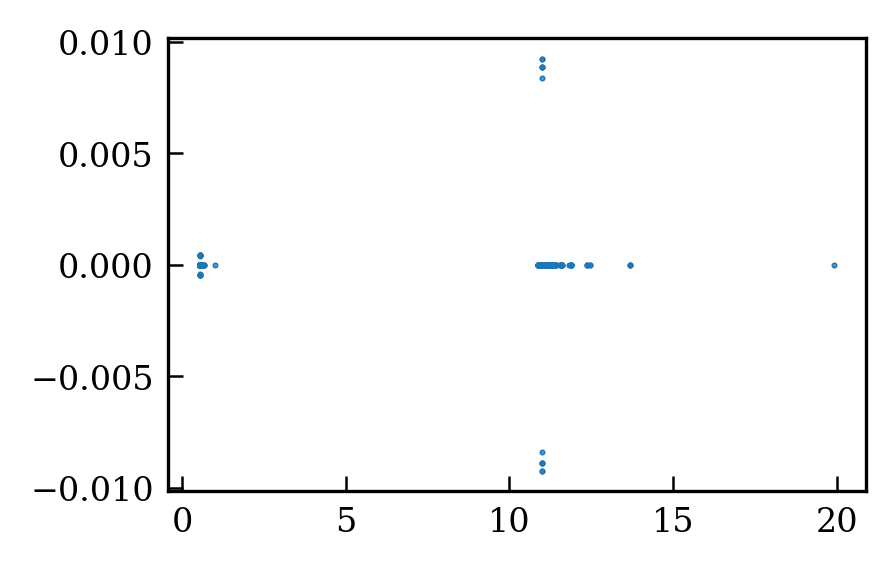

In [13]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.scatter(np.real(eig_in), np.imag(eig_in), s=0.2);

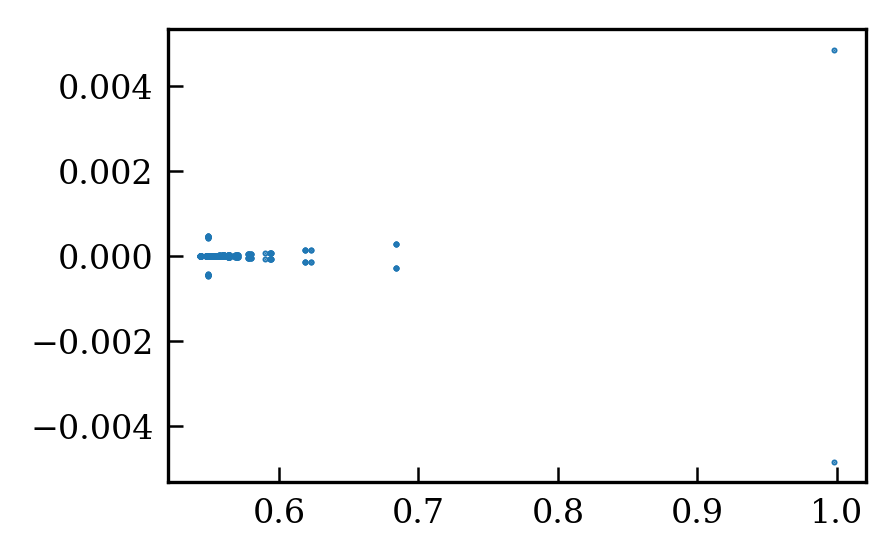

In [14]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.scatter(np.real(eig_ex), np.imag(eig_ex), s=0.2);

### Appendix:

heatmap of system matrices

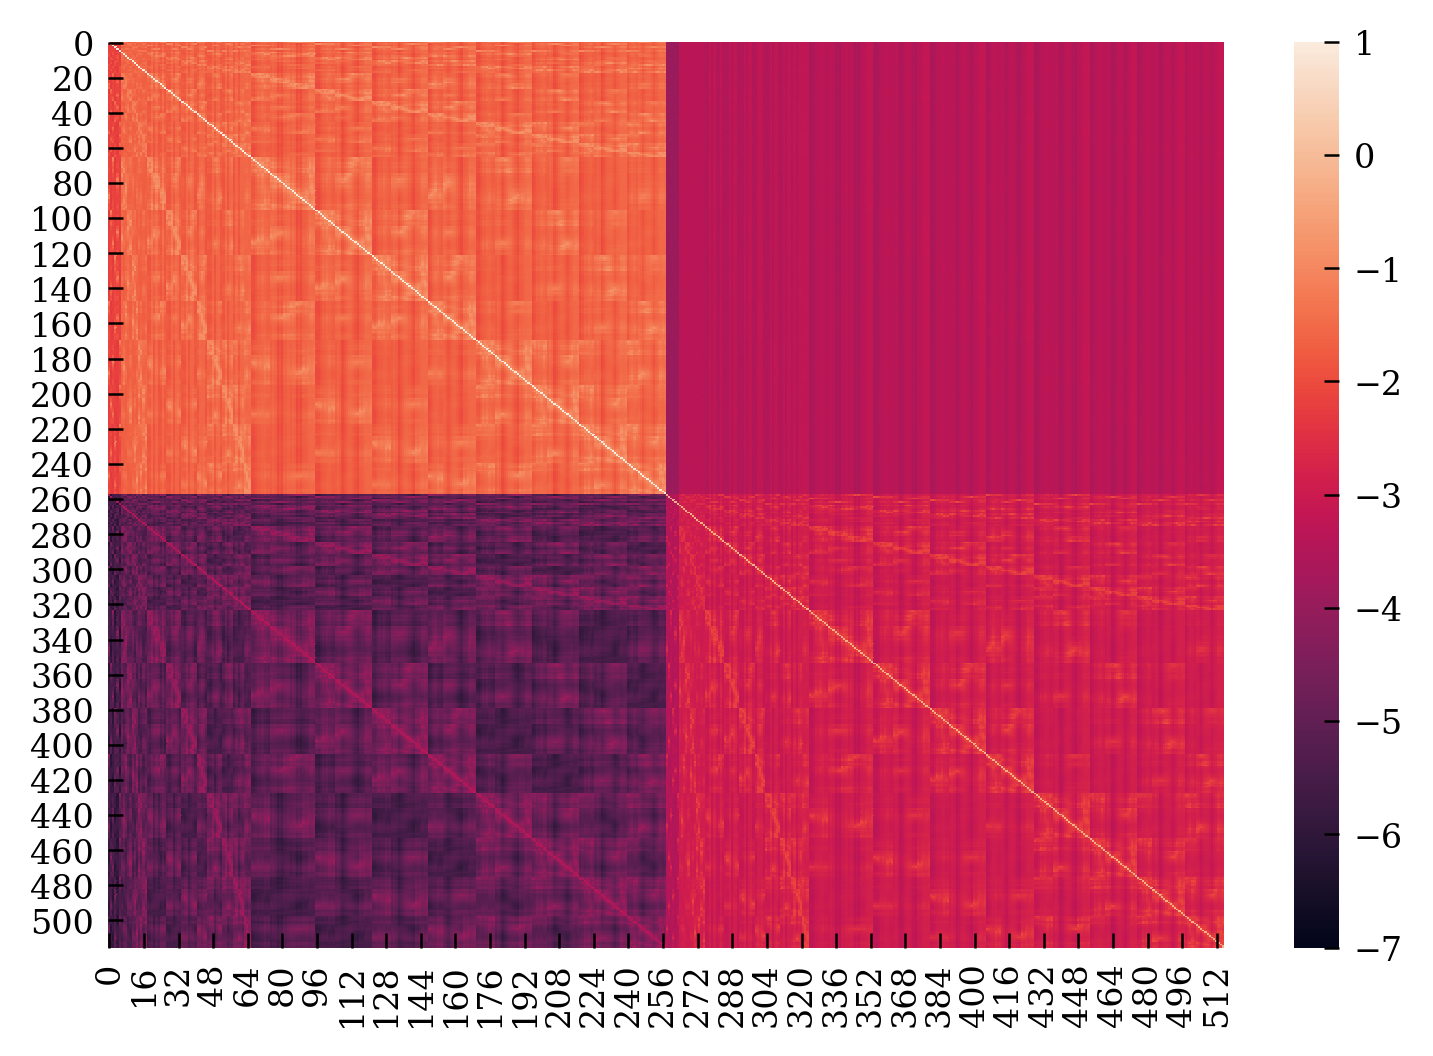

In [15]:
import seaborn as sns
sns.heatmap(np.log10(np.abs(a_inv @ mat_A_in)), vmin=-7, vmax=1);

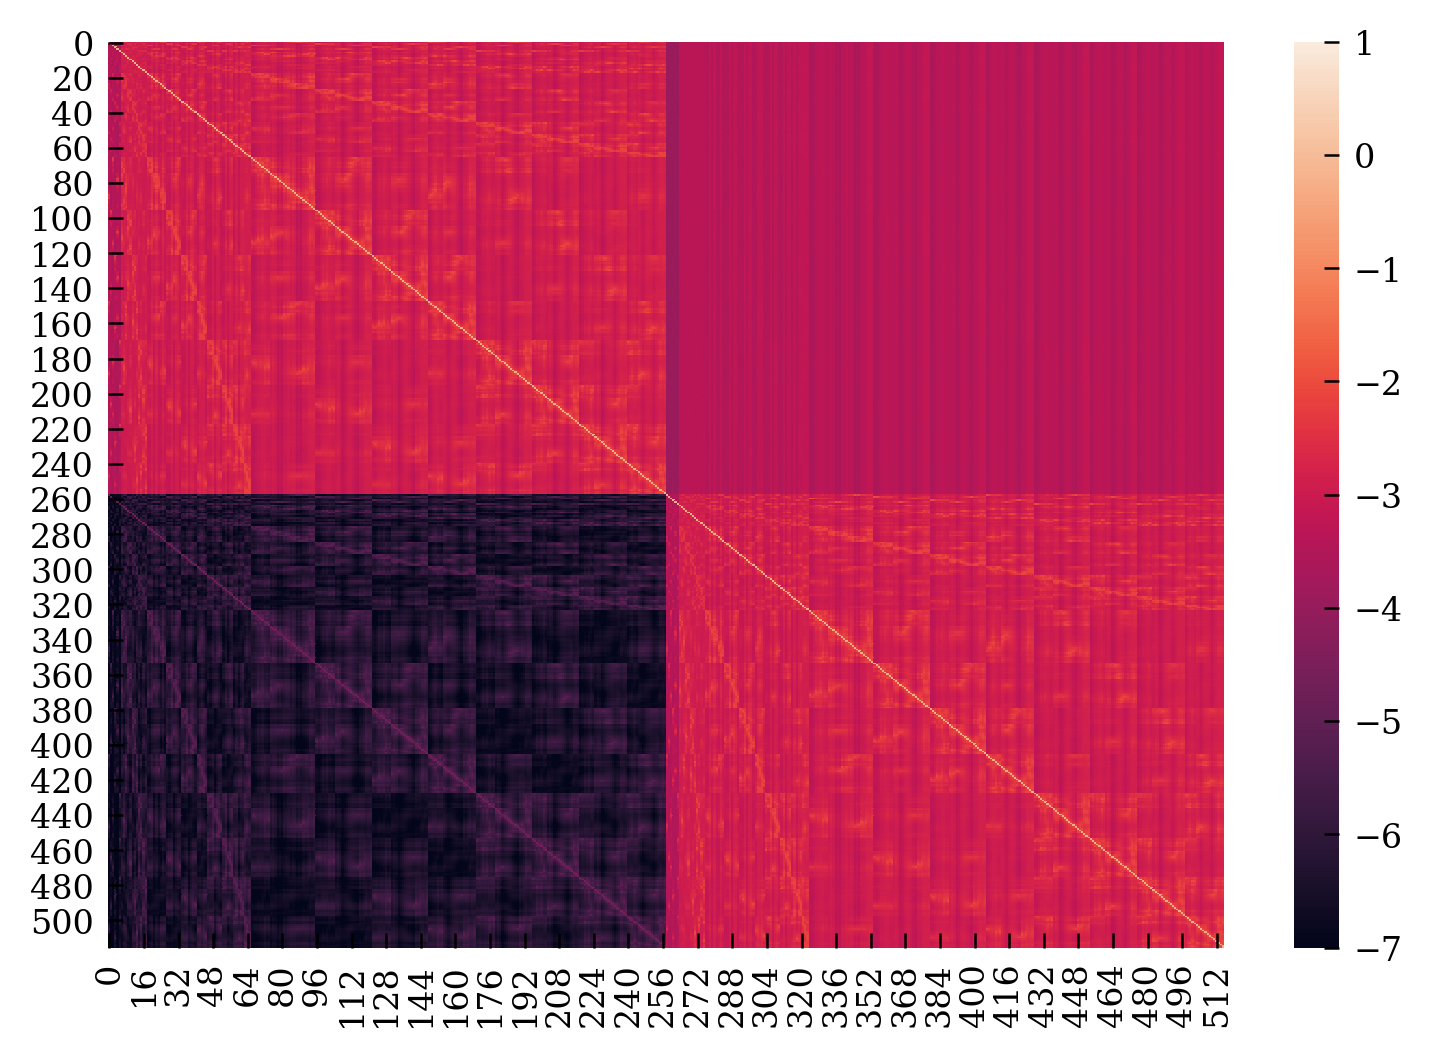

In [16]:
sns.heatmap(np.log10(np.abs(a_inv @ mat_A_ex)), vmin=-7, vmax=1);